In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from torch.utils.data import DataLoader, TensorDataset,random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os

In [ ]:
reconstructed_images = torch.load('/content/drive/MyDrive/MTP-dataset/reconstructed_cnn2.pt')
ground_truth_images = torch.load('/content/drive/MyDrive/MTP-dataset/ground_truth_cnn.pt')
ground_truth_images = ground_truth_images.view(-1,1,128,128)
reconstructed_images = reconstructed_images.view(-1,1,128,128)
dataset = TensorDataset(reconstructed_images ,ground_truth_images)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(len(train_dataset))
print(len(test_dataset))
# Create data loaders

3174
794


In [ ]:

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False,drop_last=True)

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ArtifactRemovalResNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_blocks=16):
        super(ArtifactRemovalResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.residual_blocks = self.make_residual_blocks(64, num_blocks)

        self.conv2 = nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

    def make_residual_blocks(self, channels, num_blocks):
        blocks = []
        for _ in range(num_blocks):
            blocks.append(ResidualBlock(channels, channels))
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.residual_blocks(out)

        out = self.conv2(out)

        return out


In [ ]:
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ArtifactRemovalResNet(in_channels=1 , out_channels=1).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
training_losses = []
val_losses = []

In [ ]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    for data in tqdm(train_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        training_loss += loss.item()
        loss.backward()
        optimizer.step()
    average_loss = training_loss/len(train_loader)
    training_losses.append(average_loss)
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            outputs = model(inputs.to(device).float())
            loss = criterion(outputs, targets.to(device).float())
            total_val_loss += loss.item()
    average_val_loss = total_val_loss / len(test_loader)
    val_losses.append(average_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_loss:.6f}, Validation Loss: {average_val_loss:.6f}')
torch.save(model.state_dict(), 'resnetonellipses4000.pth')

100%|██████████| 198/198 [00:08<00:00, 23.88it/s]


Epoch [1/20], Training Loss: 0.009513, Validation Loss: 0.002021


100%|██████████| 198/198 [00:08<00:00, 24.03it/s]


Epoch [2/20], Training Loss: 0.005207, Validation Loss: 0.005555


100%|██████████| 198/198 [00:08<00:00, 24.07it/s]


Epoch [3/20], Training Loss: 0.004499, Validation Loss: 0.001434


100%|██████████| 198/198 [00:08<00:00, 24.02it/s]


Epoch [4/20], Training Loss: 0.003345, Validation Loss: 0.000922


100%|██████████| 198/198 [00:08<00:00, 24.00it/s]


Epoch [5/20], Training Loss: 0.002584, Validation Loss: 0.000834


100%|██████████| 198/198 [00:08<00:00, 23.98it/s]


Epoch [6/20], Training Loss: 0.002171, Validation Loss: 0.003730


100%|██████████| 198/198 [00:08<00:00, 23.83it/s]


Epoch [7/20], Training Loss: 0.002173, Validation Loss: 0.000569


100%|██████████| 198/198 [00:08<00:00, 23.82it/s]


Epoch [8/20], Training Loss: 0.001812, Validation Loss: 0.001725


100%|██████████| 198/198 [00:08<00:00, 23.95it/s]


Epoch [9/20], Training Loss: 0.001599, Validation Loss: 0.001552


100%|██████████| 198/198 [00:08<00:00, 23.99it/s]


Epoch [10/20], Training Loss: 0.001557, Validation Loss: 0.000242


100%|██████████| 198/198 [00:08<00:00, 24.14it/s]


Epoch [11/20], Training Loss: 0.001352, Validation Loss: 0.001560


100%|██████████| 198/198 [00:08<00:00, 24.13it/s]


Epoch [12/20], Training Loss: 0.001583, Validation Loss: 0.000334


100%|██████████| 198/198 [00:08<00:00, 24.13it/s]


Epoch [13/20], Training Loss: 0.001459, Validation Loss: 0.000251


100%|██████████| 198/198 [00:08<00:00, 24.06it/s]


Epoch [14/20], Training Loss: 0.001219, Validation Loss: 0.000554


100%|██████████| 198/198 [00:08<00:00, 23.96it/s]


Epoch [15/20], Training Loss: 0.000888, Validation Loss: 0.000952


100%|██████████| 198/198 [00:08<00:00, 24.02it/s]


Epoch [16/20], Training Loss: 0.001135, Validation Loss: 0.000257


100%|██████████| 198/198 [00:08<00:00, 24.10it/s]


Epoch [17/20], Training Loss: 0.000909, Validation Loss: 0.000115


100%|██████████| 198/198 [00:08<00:00, 24.15it/s]


Epoch [18/20], Training Loss: 0.000860, Validation Loss: 0.000255


100%|██████████| 198/198 [00:08<00:00, 24.15it/s]


Epoch [19/20], Training Loss: 0.000758, Validation Loss: 0.000285


100%|██████████| 198/198 [00:08<00:00, 24.18it/s]

Epoch [20/20], Training Loss: 0.000672, Validation Loss: 0.000171


In [ ]:
training_losses = training_losses[1:]

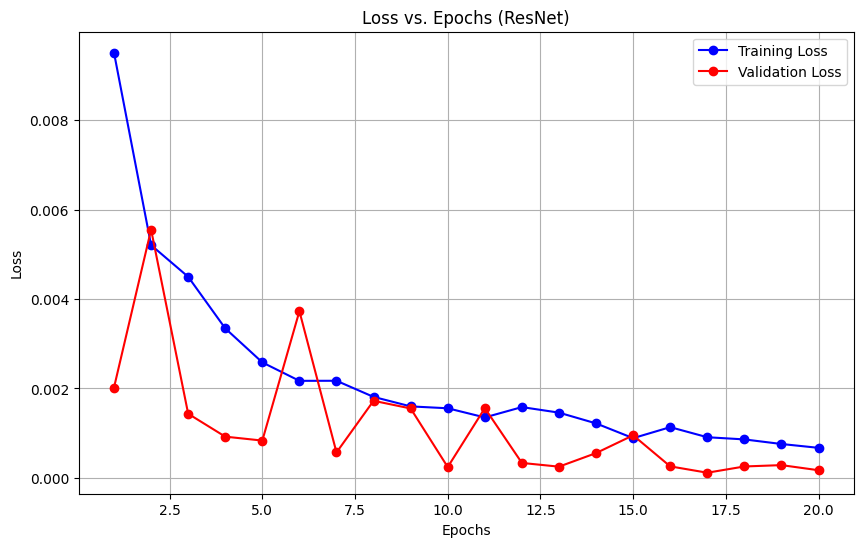

In [ ]:
epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Loss vs. Epochs (ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Average SSIM: 0.9904
Average PSNR: 40.7539
Average SSIM: 0.8896
Average PSNR: 26.4293


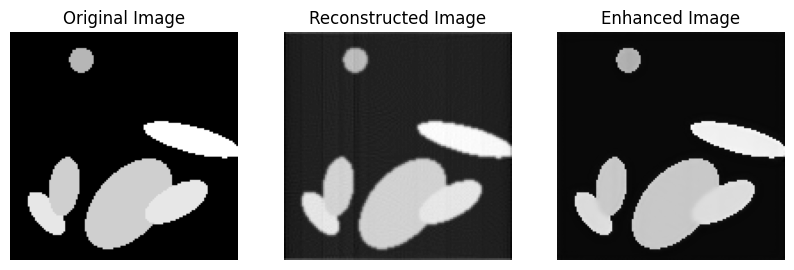

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Function to calculate SSIM for a batch of images
def batch_ssim(enhanced_images, ground_truth_images):
    ssim_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = ssim(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Function to calculate PSNR for a batch of images
def batch_psnr(enhanced_images, ground_truth_images):
    psnr_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = psnr(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        psnr_scores.append(score)
    return np.mean(psnr_scores)

# Evaluate the model and calculate SSIM and PSNR
model.eval()
all_ssim_scores = []
all_psnr_scores = []
recon_ssim = []
recon_psnr = []
printed = False
with torch.no_grad():
    for batch_reconstructed_images, batch_ground_truth_images in test_loader:
        batch_reconstructed_images = batch_reconstructed_images.to(device).float()
        batch_ground_truth_images = batch_ground_truth_images.to(device).float()
        enhanced_images = model(batch_reconstructed_images)
        if printed == False:
          printed = True
          plt.figure(figsize=(10,5))
          plt.subplot(131)
          plt.axis("off")
          plt.title("Original Image")
          plt.imshow(batch_ground_truth_images[0][0].cpu(),cmap='gray')
          plt.subplot(132)
          plt.axis("off")
          plt.title("Reconstructed Image")
          plt.imshow(batch_reconstructed_images[0][0].cpu(),cmap='gray')
          plt.subplot(133)
          plt.axis("off")
          plt.title("Enhanced Image")
          plt.imshow(enhanced_images[0][0].cpu(),cmap='gray')
        all_ssim_scores.append(batch_ssim(enhanced_images, batch_ground_truth_images))
        all_psnr_scores.append(batch_psnr(enhanced_images, batch_ground_truth_images))

        recon_ssim.append(batch_ssim(batch_reconstructed_images, batch_ground_truth_images))
        recon_psnr.append(batch_psnr(batch_reconstructed_images, batch_ground_truth_images))
        # break

# Calculate average SSIM and PSNR
avg_ssim = np.mean(all_ssim_scores)
avg_psnr = np.mean(all_psnr_scores)
rec_ssim = np.mean(recon_ssim)
rec_psnr = np.mean(recon_psnr)
print(f'Average SSIM: {avg_ssim:.4f}')
print(f'Average PSNR: {avg_psnr:.4f}')
print(f'Average SSIM: {rec_ssim:.4f}')
print(f'Average PSNR: {rec_psnr:.4f}')



In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  1185024


In [ ]:
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=Tr